In [ ]:
!pip install numpy
!pip install scipy
!pip install matplotlib
!pip install seaborn
!pip install cvxpy
!pip install POT
!pip install scikit-learn
!pip install opencv-python
!pip install torch torchvision torchaudio

In [1]:
import os
import sys
sys.path.append(os.getcwd())

import seaborn as sns
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import matplotlib.image as img
from scipy.io import loadmat
import time

from sklearn.datasets import make_moons
from sklearn.metrics import pairwise_distances
from scipy.stats import gaussian_kde
from sklearn.svm import SVC
from sklearn.cluster import KMeans

In [2]:
def measure_sparsity(solution_matrix, threshold=1e-10):
    """
    Hàm này đo lường sparsity của một ma trận, xem xét các phần tử có giá trị tuyệt đối
    nhỏ hơn ngưỡng đã chỉ định là bằng 0.

    Sparsity được định nghĩa là tỷ lệ các phần tử được xem là bằng 0 trong ma trận.

    Tham số:
    solution_matrix (np.ndarray): Ma trận cần đo lường sparsity.
    threshold (float): Ngưỡng dưới đó các phần tử được coi là bằng 0 (mặc định là 1e-10).

    Trả về:
    float: Độ sparsity của ma trận, dưới dạng giá trị từ 0 đến 1.
    """
    # Đếm số lượng phần tử được coi là bằng 0 (nhỏ hơn ngưỡng)
    zero_elements = np.sum(np.abs(solution_matrix) < threshold)

    # Tính tổng số phần tử trong ma trận
    total_elements = solution_matrix.size

    # Tính độ sparsity dưới dạng tỷ lệ của các phần tử được coi là bằng 0
    sparsity = zero_elements / total_elements

    return sparsity

In [3]:
# Hàm giải bài toán Optimal Transport (OT) không có regularizer
def solve_ot(source_hist, target_hist, C):
    n = source_hist.shape[0]
    m = target_hist.shape[0]

    # Khai báo biến
    X = cp.Variable((n, m), nonneg=True)

    # Định nghĩa các ràng buộc cho bài toán OT
    constraints = [
        cp.sum(X, axis=1) == source_hist,  # Tổng theo hàng bằng phân phối nguồn
        cp.sum(X, axis=0) == target_hist,  # Tổng theo cột bằng phân phối đích
    ]

    # Định nghĩa hàm mục tiêu chỉ với cost matrix C mà không có regularizer
    objective = cp.Minimize(cp.sum(cp.multiply(C, X)))

    # Định nghĩa và giải bài toán
    prob = cp.Problem(objective, constraints)
    prob.solve()

    return X.value, prob.value


# Hàm giải POT với quadratic regularizer
def solve_pot_quadratic_regularization(source_hist, target_hist, C, s, epsilon):
    n = source_hist.shape[0]
    m = target_hist.shape[0]

    # Khai báo biến
    X = cp.Variable((n, m), nonneg=True)

    # Định nghĩa các ràng buộc cho bài toán POT
    constraints = [
        cp.sum(X, axis=1) <= source_hist,
        cp.sum(X, axis=0) <= target_hist,
        cp.sum(X) == s,
    ]

    # Định nghĩa hàm mục tiêu với regularization quadratic
    objective = cp.Minimize(cp.trace(C.T @ X) + (epsilon / 2) * cp.norm(X, "fro") ** 2)

    # Định nghĩa và giải bài toán
    prob = cp.Problem(objective, constraints)
    prob.solve()

    return X.value, prob.value

Domain adaptation là một nhánh của học chuyển giao (transfer learning) với mục tiêu áp dụng một model đã được huấn luyện trên một nguồn dữ liệu (source domain) sang một miền mục tiêu (target domain) khác nhưng có liên quan.  
Thách thức chính trong domain adaptation là sự khác biệt giữa các phân phối dữ liệu của miền nguồn và miền mục tiêu, điều này làm cho model được huấn luyện trên miền nguồn có thể không hoạt động tốt trên miền mục tiêu.

**Các khái niệm chính**
- **Source Domain ($\mathcal{D}_S$)**: Miền nơi có sẵn dữ liệu huấn luyện.
- **Target Domain ($\mathcal{D}_T$)**: Miền mục tiêu nơi model cần được áp dụng, nhưng có ít hoặc không có dữ liệu gán nhãn.
- **Source Distribution ($P_S(X, Y)$)**: Phân phối chung của các đặc trưng đầu vào $X$ và nhãn $Y$ trong source domain.
- **Target Distribution ($P_T(X, Y)$)**: Phân phối chung của các đặc trưng đầu vào $X$ và nhãn $Y$ trong target domain.

**Bài toán**
Trong domain adaptation, mục tiêu là giảm thiểu lỗi trên target domain. Tuy nhiên, vì các phân phối $P_S(X, Y)$ và $P_T(X, Y)$ khác nhau, một model được huấn luyện trên $P_S(X, Y)$ có thể không tổng quát hóa tốt trên $P_T(X, Y)$. Mục tiêu là tìm một phép chiếu hoặc một model giúp giảm sự khác biệt giữa hai phân phối này.

**Công thức toán học**

Với một source domain $\mathcal{D}_S$ có phân phối $P_S(X, Y)$ và một target domain $\mathcal{D}_T$ có phân phối $P_T(X, Y)$, mục tiêu là giảm thiểu tổn thất kỳ vọng trên target domain:

$$
\mathcal{L}_T(h) = \mathbb{E}_{(X_T, Y_T) \sim P_T} \left[ \ell(h(X_T), Y_T) \right],
$$

trong đó $h$ là model hoặc giả thuyết, $\ell$ là hàm mất mát, $X_T$ và $Y_T$ là các đặc trưng đầu vào và nhãn trong target domain.

Vì $P_T(X, Y)$ khác với $P_S(X, Y)$, một phương pháp phổ biến trong domain adaptation là giảm thiểu sự khác biệt giữa các phân phối $P_S(X)$ và $P_T(X)$. Điều này có thể được thực hiện bằng các kỹ thuật như:

- **Domain-Invariant Feature Learning**: Học các đặc trưng mà không phụ thuộc vào domain, sao cho $P_S(\phi(X)) \approx P_T(\phi(X))$ trong đó $\phi(X)$ là biểu diễn đặc trưng.
- **Adversarial Training**: Sử dụng một bộ phân biệt domain để phân biệt giữa source và target domains và huấn luyện bộ trích xuất đặc trưng để gây nhiễu cho bộ phân biệt.

**Tóm tắt**

Domain adaptation tìm cách thu hẹp khoảng cách giữa các domain khác nhau bằng cách học các model hoặc biểu diễn có khả năng hoạt động tốt trên target domain, ngay cả khi được huấn luyện trên source domain với các phân phối dữ liệu khác nhau.

### a) Helper functions

In [ ]:
def make_moons_da2(n_samples1=(150, 150), n_samples2=None, rotation=50, noise=0.05):
    # Nếu n_samples2 không được cung cấp, sử dụng giá trị của n_samples1
    if n_samples2 is None:
        n_samples2 = n_samples1

    # Tạo tập dữ liệu nguồn (source dataset) với mẫu 'moons'
    Xs, ys = make_moons(n_samples=n_samples1, noise=noise, random_state=42)
    # Dịch chuyển dữ liệu nguồn để căn giữa
    Xs[:, 0] -= 0.5
    Xs[:, 1] -= 0.25

    # Tạo tập dữ liệu mục tiêu (target dataset) với mẫu 'moons'
    Xt, yt = make_moons(n_samples=n_samples2, noise=noise, random_state=42)
    # Dịch chuyển dữ liệu mục tiêu để căn giữa
    Xt[:, 0] -= 0.5
    Xt[:, 1] -= 0.25

    # Tính toán góc xoay (radians) từ giá trị 'rotation' (độ)
    theta = np.radians(-rotation)
    cos_theta, sin_theta = np.cos(theta), np.sin(theta)
    # Tạo ma trận xoay 2x2
    rot_matrix = np.array(((cos_theta, -sin_theta), (sin_theta, cos_theta)))
    # Áp dụng phép xoay lên tập dữ liệu mục tiêu
    Xt = Xt.dot(rot_matrix)

    # Trả về các tập dữ liệu nguồn và mục tiêu cùng với nhãn tương ứng
    return Xs, ys, Xt, yt

In [ ]:
def plot_deicion_boundary(Xs, ys, Xt, yt, hat_Xs, svc, ax):
    # Tạo một lưới điểm để vẽ ranh giới quyết định
    h = 0.02  # Bước nhảy cho lưới điểm
    x_min, x_max = (
        hat_Xs[:, 0].min() - 1,
        hat_Xs[:, 0].max() + 1,
    )  # Xác định biên giới của trục x
    y_min, y_max = (
        hat_Xs[:, 1].min() - 1,
        hat_Xs[:, 1].max() + 1,
    )  # Xác định biên giới của trục y
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, h),  # Tạo lưới điểm từ x_min đến x_max
        np.arange(y_min, y_max, h),
    )  # Tạo lưới điểm từ y_min đến y_max

    # Sử dụng hàm quyết định để nhận được các giá trị liên tục
    Z = svc.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)  # Định hình lại Z thành dạng ma trận của lưới

    # Vẽ các đường viền (contours) cho lớp 0 (blue) và lớp 1 (red)
    ax.contour(
        xx, yy, Z, levels=[0], colors="black", linestyles="--"
    )  # Decision boundary
    ax.contour(xx, yy, Z, levels=[-1], colors="blue", linestyles="-")  # Class 0 contour
    ax.contour(xx, yy, Z, levels=[1], colors="red", linestyles="-")  # Class 1 contour

    # Tính toán KDE (Kernel Density Estimation) cho lớp 0
    x1, y1 = hat_Xs[ys == 0, 0], hat_Xs[ys == 0, 1]  # Lấy các điểm dữ liệu thuộc lớp 0
    xy1 = np.vstack([x1, y1])  # Tạo mảng chứa cả x1 và y1
    z1 = gaussian_kde(xy1)(
        np.c_[xx.ravel(), yy.ravel()].T
    )  # Tính mật độ KDE cho từng điểm trên lưới

    # Tính toán KDE cho lớp 1
    x2, y2 = hat_Xs[ys == 1, 0], hat_Xs[ys == 1, 1]  # Lấy các điểm dữ liệu thuộc lớp 1
    xy2 = np.vstack([x2, y2])  # Tạo mảng chứa cả x2 và y2
    z2 = gaussian_kde(xy2)(
        np.c_[xx.ravel(), yy.ravel()].T
    )  # Tính mật độ KDE cho từng điểm trên lưới

    # Vẽ điểm trên lưới với giá trị dựa trên sự chênh lệch mật độ giữa hai lớp
    ax.scatter(
        xx.ravel(),
        yy.ravel(),
        c=z1 / (max(z1) - min(z1))
        - z2 / (max(z2) - min(z2)),  # Màu sắc dựa trên sự chênh lệch KDE
        s=5,
        cmap="RdBu",
    )  # Kích thước điểm và màu sắc

    # Vẽ các điểm dữ liệu của tập nguồn thuộc lớp 0
    ax.scatter(Xs[ys == 0, 0], Xs[ys == 0, 1], label="source", c="tab:blue", s=2)

    # Vẽ các điểm dữ liệu của tập nguồn thuộc lớp 1
    ax.scatter(Xs[ys == 1, 0], Xs[ys == 1, 1], label="source", c="tab:red", s=2)

    # Vẽ các điểm dữ liệu của tập mục tiêu
    ax.scatter(Xt[:, 0], Xt[:, 1], label="target", c="black", s=2)

### b) Thực hiện domain adaptation

#### Tạo moon dataset

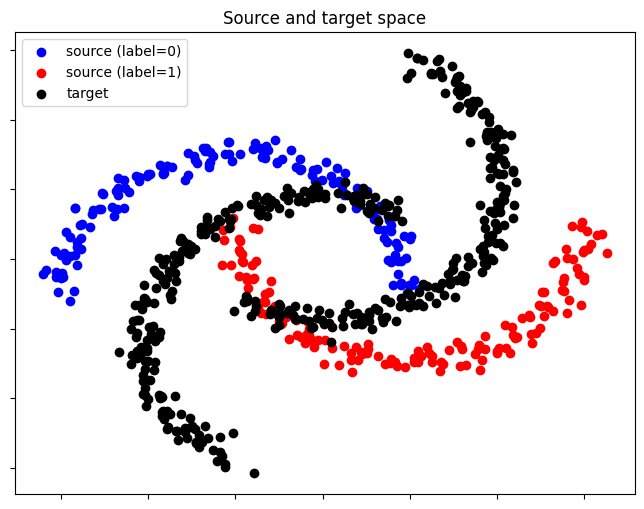

In [ ]:
# Tạo dữ liệu nguồn (Xs, ys) và dữ liệu mục tiêu (Xt, yt) với phép xoay 50 độ
Xs, ys, Xt, yt = make_moons_da2(
    rotation=60, n_samples1=(150, 150), n_samples2=(200, 200)
)

fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))
ax1.set_title("Source and target space")
# Vẽ các điểm dữ liệu của nhãn 0 trong tập nguồn (label=0)
ax1.scatter(Xs[ys == 0, 0], Xs[ys == 0, 1], label="source (label=0)", c="blue")
# Vẽ các điểm dữ liệu của nhãn 1 trong tập nguồn (label=1)
ax1.scatter(Xs[ys == 1, 0], Xs[ys == 1, 1], label="source (label=1)", c="red")
# Vẽ các điểm dữ liệu trong tập mục tiêu
ax1.scatter(Xt[:, 0], Xt[:, 1], label="target", c="black")
ax1.legend(loc="best")
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.tick_params(direction="out")

# Tạo thêm một bộ test set để tính độ sai số sau khi thực hiện vận chuyển
rotation = 50
X_test, y_test = make_moons(n_samples=(10000, 10000), noise=0.05)
X_test[:, 0] -= 0.5
X_test[:, 1] -= 0.25
theta = np.radians(-rotation)
cos_theta, sin_theta = np.cos(theta), np.sin(theta)
rot_matrix = np.array(((cos_theta, -sin_theta), (sin_theta, cos_theta)))
X_test = X_test.dot(rot_matrix)

#### Tính các vector khối lượng và cost matrix

Tính vector khối lượng 2 phân phối

In [ ]:
# Mỗi phần tử của 'r' và 'c' đại diện cho xác suất liên quan đến một điểm dữ liệu trong 'Xs' và 'Xt'.
# Tất cả các xác suất đều bằng nhau, và tổng tất cả các xác suất là 1.

# Tạo phân phối xác suất đều cho tập dữ liệu source
r = np.ones(Xs.shape[0]) / Xs.shape[0]
# Tạo phân phối xác suất đều cho tập dữ liệu target
c = np.ones(Xt.shape[0]) / Xt.shape[0]

Sử dụng KMeans để gom các phần tử ở phân phối có nhiều mẫu hơn để cân bằng số lượng 2 phân phối

In [ ]:
# Lấy số lượng mẫu trong tập nguồn và tập mục tiêu
ns, nt = Xs.shape[0], Xt.shape[0]

# Xác định số lượng cụm (clusters) là số nhỏ hơn giữa ns và nt
n_clusters = min(ns, nt)

# Khởi tạo phân phối xác suất đều cho tập nguồn (r) và tập mục tiêu (c)
r = np.ones(Xs.shape[0])  # Tất cả các phần tử trong r bằng 1
c = np.ones(Xt.shape[0])  # Tất cả các phần tử trong c bằng 1

# Nếu số lượng mẫu trong tập nguồn ít hơn tập mục tiêu
if ns < nt:
    print("Số lượng mẫu trong nguồn ít hơn mục tiêu")
    # Áp dụng k-means clustering lên tập mục tiêu Xt để giảm số lượng điểm dữ liệu
    km = KMeans(n_clusters=n_clusters, n_init=1, max_iter=300, random_state=100).fit(Xt)
    centers = km.cluster_centers_  # Lấy tọa độ các tâm cụm sau khi clustering
    labels = km.labels_  # Lấy nhãn cụm của mỗi điểm dữ liệu trong Xt

    # Thay thế tập mục tiêu Xt bằng các tâm cụm
    Xt = centers
    # Cập nhật phân phối c với số lượng điểm dữ liệu trong mỗi cụm
    c = np.bincount(labels, minlength=n_clusters).astype(np.float64)

# Nếu số lượng mẫu trong tập nguồn nhiều hơn tập mục tiêu
elif ns > nt:
    print("Số lượng mẫu trong mục tiêu ít hơn nguồn")
    # Áp dụng k-means clustering lên tập nguồn Xs để giảm số lượng điểm dữ liệu
    km = KMeans(n_clusters=n_clusters, n_init=1, max_iter=300, random_state=100).fit(Xs)
    centers = km.cluster_centers_  # Lấy tọa độ các tâm cụm sau khi clustering
    labels = km.labels_  # Lấy nhãn cụm của mỗi điểm dữ liệu trong Xs

    # Thay thế tập nguồn Xs bằng các tâm cụm
    Xs = centers
    # Cập nhật phân phối r với số lượng điểm dữ liệu trong mỗi cụm
    r = np.bincount(labels, minlength=n_clusters).astype(np.float64)

Số lượng mẫu trong nguồn ít hơn mục tiêu


Chuẩn hóa 2 phân phối

In [ ]:
# Chuẩn hóa phân phối r và c để tổng khối lượng bằng 1
r /= r.sum()
c /= c.sum()

Tính cost matrix

In [ ]:
# 'C' là ma trận chi phí, trong đó mỗi phần tử 'C[i, j]' biểu thị khoảng cách bình phương Euclidean
# giữa điểm thứ i trong 'Xs' và điểm thứ j trong 'Xt'.

# Tính toán ma trận chi phí C giữa các điểm trong 'Xs' và 'Xt' dựa trên khoảng cách bình phương Euclidean
C = pairwise_distances(Xs, Xt, metric="sqeuclidean")
# Chuẩn hóa ma trận chi phí C để giá trị tối đa trong C là 1
C /= C.max()

# Tính toán khối lượng tối thiểu cần thiết để vận chuyển giữa 'r' và 'c'
lambda_param = 0.9999
s = lambda_param*min(r.sum(), c.sum())

#### Thực hiện Domain Adaptation bằng OT

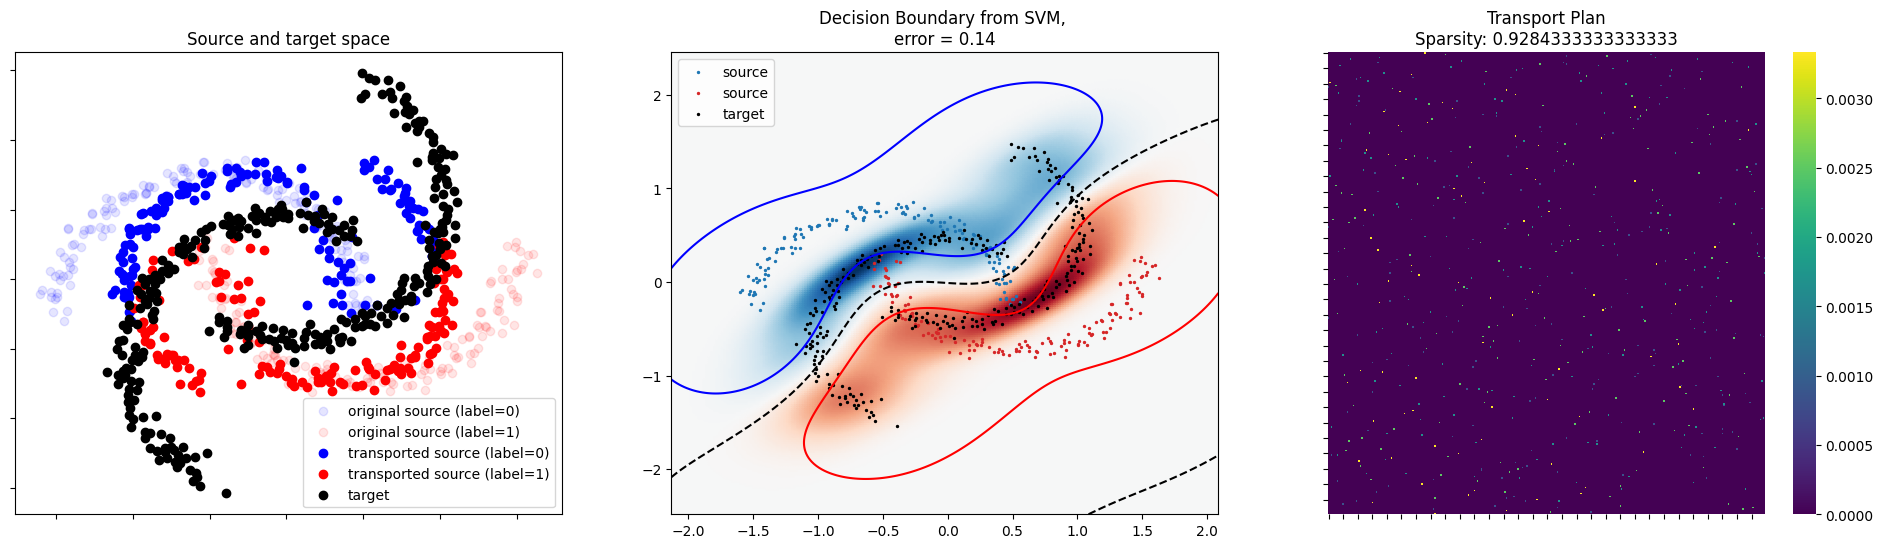

In [ ]:
start_time = time.time()
# Giải bài toán vận chuyển tối ưu (POT) với regularization bậc hai
T_ot, W_ot = solve_ot(r, c, C)
# Áp dụng kế hoạch vận chuyển (transport plan) để biến đổi dữ liệu nguồn
hat_Xs = Xs.shape[0] * (T_ot @ Xt)
runtime = time.time() - start_time
runtimes.append(runtime)

# Train SVM trên dữ liệu nguồn đã biến đổi
svclassifier = SVC(kernel='rbf')
svclassifier.fit(hat_Xs, ys)
# Test error của SVM
error = np.round(np.mean(svclassifier.predict(X_test) != y_test), 2)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))
ax1.set_title("Source and target space")
# Vẽ dữ liệu nguồn ban đầu (label=0 và label=1) với độ trong suốt alpha=0.1
ax1.scatter(
    Xs[ys == 0, 0],
    Xs[ys == 0, 1],
    label="original source (label=0)",
    c="blue",
    alpha=0.1,
)
ax1.scatter(
    Xs[ys == 1, 0],
    Xs[ys == 1, 1],
    label="original source (label=1)",
    c="red",
    alpha=0.1,
)
# Vẽ dữ liệu nguồn sau khi biến đổi (label=0 và label=1)
ax1.scatter(
    hat_Xs[ys == 0, 0],
    Xs[ys == 0, 1],
    label="transported source (label=0)",
    c="blue",
)
ax1.scatter(
    hat_Xs[ys == 1, 0],
    Xs[ys == 1, 1],
    label="transported source (label=1)",
    c="red",
)  
# Vẽ dữ liệu mục tiêu
ax1.scatter(Xt[:, 0], Xt[:, 1], label="target", c="black")

ax1.legend(loc="best")
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.tick_params(direction="out")

# Vẽ ranh giới quyết định của SVM sau khi huấn luyện trên dữ liệu nguồn đã biến đổi
ax2.set_title("Decision Boundary from SVM, \nerror = " + str(error))
plot_deicion_boundary(Xs, ys, Xt, yt, hat_Xs, svclassifier, ax2)
ax2.legend(loc="upper left")

# Vẽ ma trận kế hoạch vận chuyển (transport plan) dưới dạng heatmap
ax3.set_title(
    "Transport Plan\nSparsity: "
    + str(measure_sparsity(T_ot))
)
sns.heatmap(T_ot, cmap=sns.color_palette("viridis", as_cmap=True), ax=ax3)
ax3.set_yticklabels([])
ax3.set_xticklabels([])

plt.show()

#### Thực hiện Domain Adaptation bằng QPOT trên nhiều epsilon khác nhau

In [ ]:
# Run the POT solver
pot_implemented = True
epsilon = 1e-2
results = []
runtimes = []
epsilons = [1e-2, 1e-1, 1, 10, 100]
for epsilon in epsilons:
    start_time = time.time()
    # Giải bài toán vận chuyển tối ưu (POT) với regularization bậc hai
    try:
        T_pot, W_pot = solve_pot_quadratic_regularization(r, c, C, s, epsilon)
    except NotImplementedError:
        pot_implemented = False
        break
    # Áp dụng kế hoạch vận chuyển (transport plan) để biến đổi dữ liệu nguồn
    hat_Xs = Xs.shape[0] * (T_pot @ Xt)
    runtime = time.time() - start_time
    runtimes.append(runtime)

    # Train SVM trên dữ liệu nguồn đã biến đổi
    svclassifier = SVC(kernel='rbf')
    svclassifier.fit(hat_Xs, ys)
    # Test error của SVM
    error = np.round(np.mean(svclassifier.predict(X_test) != y_test), 2)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))
    ax1.set_title("Source and target space \nepsilon = " + str(epsilon))
    # Vẽ dữ liệu nguồn ban đầu (label=0 và label=1) với độ trong suốt alpha=0.1
    ax1.scatter(
        Xs[ys == 0, 0],
        Xs[ys == 0, 1],
        label="original source (label=0)",
        c="blue",
        alpha=0.1,
    )
    ax1.scatter(
        Xs[ys == 1, 0],
        Xs[ys == 1, 1],
        label="original source (label=1)",
        c="red",
        alpha=0.1,
    )
    # Vẽ dữ liệu nguồn sau khi biến đổi (label=0 và label=1)
    ax1.scatter(
        hat_Xs[ys == 0, 0],
        Xs[ys == 0, 1],
        label="transported source (label=0)",
        c="blue",
    )
    ax1.scatter(
        hat_Xs[ys == 1, 0],
        Xs[ys == 1, 1],
        label="transported source (label=1)",
        c="red",
    )  
    # Vẽ dữ liệu mục tiêu
    ax1.scatter(Xt[:, 0], Xt[:, 1], label="target", c="black")

    ax1.legend(loc="best")
    ax1.set_yticklabels([])
    ax1.set_xticklabels([])
    ax1.tick_params(direction="out")

    # Vẽ ranh giới quyết định của SVM sau khi huấn luyện trên dữ liệu nguồn đã biến đổi
    ax2.set_title("Decision Boundary from SVM, \nerror = " + str(error))
    plot_deicion_boundary(Xs, ys, Xt, yt, hat_Xs, svclassifier, ax2)
    ax2.legend(loc="upper left")

    # Vẽ ma trận kế hoạch vận chuyển (transport plan) dưới dạng heatmap
    ax3.set_title(
        "Transport Plan\n Epsilon: "
        + str(epsilon)
        + ", Sparsity: "
        + str(measure_sparsity(T_pot))
    )
    sns.heatmap(T_pot, cmap=sns.color_palette("viridis", as_cmap=True), ax=ax3)
    ax3.set_yticklabels([])
    ax3.set_xticklabels([])

if pot_implemented:
    # Visualize runtime comparison
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar([str(eps) for eps in epsilons], runtimes, color="blue")
    ax.set_xlabel("Epsilon values")
    ax.set_ylabel("Runtime (seconds)")
    ax.set_title("Runtime Comparison for Different Epsilon Values")

    # Annotate bars with runtime values
    for bar in bars:
        yval = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            round(yval, 4),
            ha="center",
            va="bottom",
        )

    plt.show()

#### Thực hiện Domain Adaptation bằng QPOT trên nhiều ... khác nhau